# Notebook 2: Bayesian regression

### Gaussian processes are popular methods for non-linear regression. In this notebook we show a simple example of fitting a model to one-dimensional data from a simple function.

Notebook created by Sumon Ahmed, Magnus Rattray and Alexis Boukouvalas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gpflow
tf.logging.set_verbosity(tf.logging.ERROR) # Suppresses tensorflow messages

/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

In [2]:
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

### Example data is from this simple Sine curve

In [3]:
def f(x):
    return np.sin(x)

(0, 6)

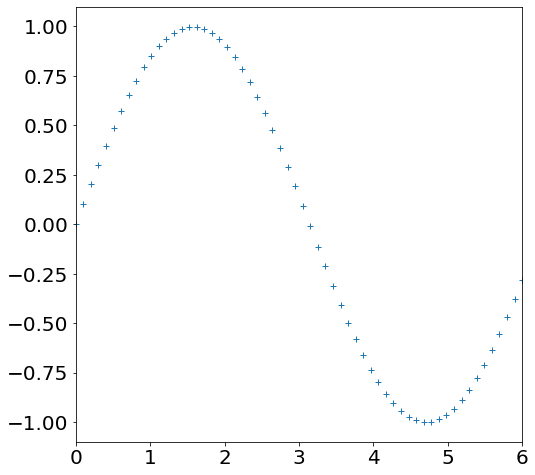

In [4]:
plt.figure(figsize=(8, 8))
x = np.linspace(0, 6, 60)
y = f(x)
plt.plot(x, y, '+')
plt.xlim([0,6])

### First let's generate some sample functions from the kernel we are using. These are samples from the prior distribution, before we have observed any data. This shows us the typical characteristics of the functions we expect to see. The squared exponential (aka RBF) kernel assumes the function underlying our data will be smooth and has a characteristic timescale.

(0, 6)

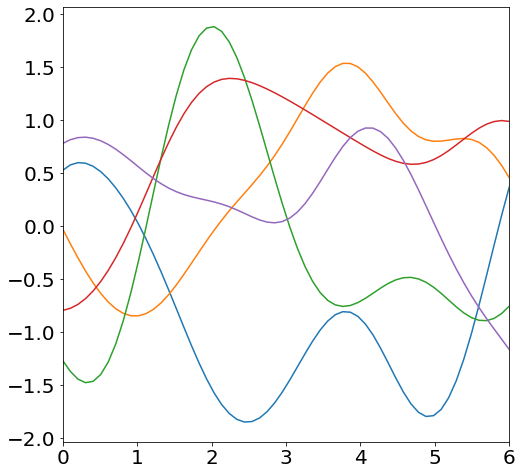

In [5]:
plt.figure(figsize=(8, 8))
sampleSize = 60
n_sample = 5
k = gpflow.kernels.RBF(1) # RBF or squared exponential kernel
k.lengthscales = 1.       # The default value before fitting to data
k.variance = 1.           # The default value before fitting to data
np.random.seed(1)         # Change this to get different samples
K = k.compute_K_symm(x[:,None])
plt.plot(x, np.random.multivariate_normal(np.zeros(sampleSize), K, n_sample).T)
plt.xlim([0,6])

### Now create a small dataset with 4 points

In [6]:
X = np.array([1., 2., 3., 5.])
Y = f(X)
print(Y)

[ 0.84147098  0.90929743  0.14112001 -0.95892427]


### Create the regression model for these four data points

In [7]:
X = np.array([1., 2., 3., 5.])
Y = f(X)
with gpflow.defer_build():
    m = gpflow.models.GPR(X[:, None], Y[:, None], kern=gpflow.kernels.RBF(1))
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m) # Fit the hyper-parameters by maximum likelihood

### After training the model we can look at the learned model hyper-parameters

In [8]:
m

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.5114036274897131
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.6100105491170786
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0276454553203052e-06


### The RBF kernel has two hyper-parameters, the lengthscale $l$ and the variance $\alpha$. There is an additional model parameter, the observation noise variance $\sigma^2$, which is considered part of the likelihood function rather than the kernel function. 

### Below we plot the predictive mean and variance, and some samples from the posterior

In [9]:
mean, var = m.predict_y(x[:,None])       # Mean and variance of the predicted function at each x
f1 = m.predict_f_samples(x[:,None], 5)   # 5 samples from the posterior

(0, 6)

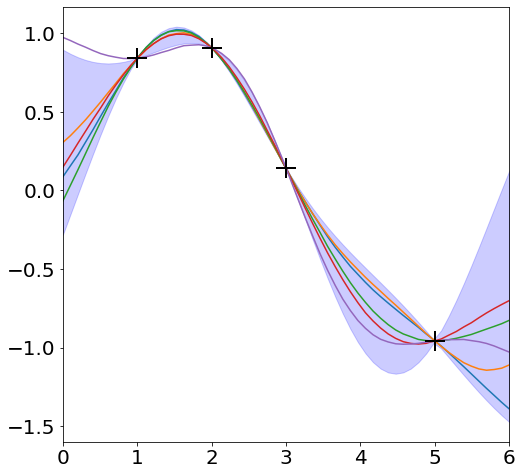

In [10]:
plt.figure(figsize=(8,8))
plt.fill_between(x[:,None][:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
plt.plot(x[:,None], f1[0,:,:])
plt.plot(x[:,None], f1[1,:,:])
plt.plot(x[:,None], f1[2,:,:])
plt.plot(x[:,None], f1[3,:,:])
plt.plot(x[:,None], f1[4,:,:])
plt.plot(X, Y, '+', color='black', ms=20, markeredgewidth=2)
plt.xlim(0, 6)

### We only used four data points for the previous model. Now we'll try it with 10 and we'll add some noise to the observations

In [11]:
X1 = np.array([0.5, 1.0, 1.5, 2, 2.5, 3., 3.5, 4., 4.5, 5.])
Y1 = f(X1)
np.random.seed(1) # Change this to get different random noise added to the data
for i in range(len(Y1)):
    Y1[i] = Y1[i] + np.random.normal(1)*0.1 # Adding noise with standard deviation 0.1 (variance 0.01)
with gpflow.defer_build():
    m1 = gpflow.models.GPR(X1[:, None], Y1[:, None], kern=gpflow.kernels.RBF(1))
m1.compile()
opt1 = gpflow.train.ScipyOptimizer()
opt1.minimize(m1) # Fit the hyper-parameters by maximum likelihood

In [12]:
m1

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.6939558935043446
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.5908971567027048
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01852041148212459


### The noise variance in the data is 0.01 so we're not too far off here. With only 10 data points and no replicates it is unlikely that we could estimate the noise level very precisely. 

### Below we plot the predictive mean and variance, and some samples from the posterior

(0, 6)

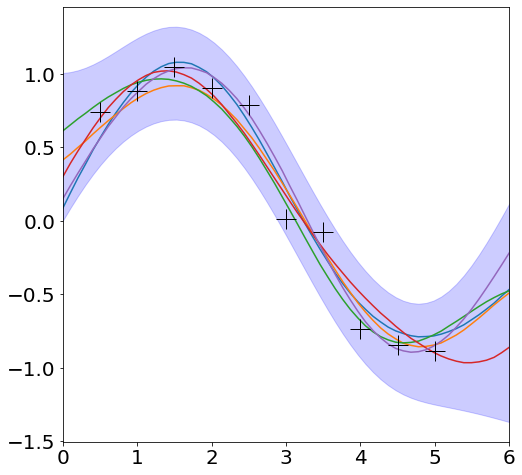

In [13]:
mean1, var1 = m1.predict_y(x[:,None])
f2 = m1.predict_f_samples(x[:,None], 5)

plt.figure(figsize=(8,8))

# plt.plot(x[:,None], mean, 'b', lw=2)
plt.fill_between(x[:,None][:,0], mean1[:,0] - 2*np.sqrt(var1[:,0]), mean1[:,0] + 2*np.sqrt(var1[:,0]), color='blue', alpha=0.2)
plt.plot(x[:,None], f2[0,:,:])
plt.plot(x[:,None], f2[1,:,:])
plt.plot(x[:,None], f2[2,:,:])
plt.plot(x[:,None], f2[3,:,:])
plt.plot(x[:,None], f2[4,:,:])

plt.plot(X1, Y1, '+', color='black', ms=20)
plt.xlim(0, 6)

# Exercises:

### 1) How does the above prediction change as you increase or reduce the noise in the data?

### 2) Do you think there are functions that don't satisfy some of the assumptions of the RBF kernel? As an example, try fitting data coming from a step function

```def h(x):
    return np.greater(x,0).astype(float)
    ```